https://strawberryfields.ai/photonics/demos/run_GKP_bosonic.html

In [22]:
# Imports
import strawberryfields as sf
from strawberryfields import ops
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import colors, colorbar 
from matplotlib import cm
import time
sf.hbar = 1


def plot_wigner_functions(states, titles=None, figsize=(12, 6)):
    """
    Plot the Wigner functions of given quantum states in subplots.

    :param states: List of quantum states to plot.
    :param titles: List of titles for the subplots. If None, default titles are used.
    :param figsize: Tuple representing the figure size.
    """
    # Set the scale for phase space
    sf.hbar = 1
    scale = np.sqrt(sf.hbar * np.pi)
    quad = np.linspace(-3.5, 3.5, 200) * scale
    
    # Create a figure for subplots
    fig, axs = plt.subplots(1, len(states), figsize=figsize)
    if len(states) == 1:
        axs = [axs]  # Make sure axs is iterable when there's only one subplot

    # Calculate and store Wigner functions and find maximum value for normalization
    wigners = [state.wigner(mode=0, xvec=quad, pvec=quad) for state in states]
    cmax = np.max([np.abs(np.amax(wigner)) for wigner in wigners])

    # Plot each state's Wigner function
    for i, (ax, wigner) in enumerate(zip(axs, wigners)):
        title = f"Wigner function for State {i}" if titles is None else titles[i]
        cp = ax.contourf(quad / scale, quad / scale, wigner, levels=60, cmap=plt.cm.RdBu,
                         norm=colors.Normalize(vmin=-cmax, vmax=cmax))
        ax.set_title(title)
        ax.set_xlabel(r'$q$ (units of $\sqrt{\pi}$)')
        ax.set_ylabel(r'$p$ (units of $\sqrt{\pi}$)')

    plt.show()

# Gottesman-Kitaev-Preskill Codes
Note: Throughout we shift from $q $ and $ x$ to represent the position quadrature.

To begin with, we'll use strawberry fields in order to visualise and better understand GKP code in phase space. We know that the stabilizers for the GKP code are the displacement operators:
$$
\large \hat{S}_x = e^{-i 2 \sqrt{\pi} \hat{p}} \quad \hat{S}_p = e^{i 2 \sqrt{\pi} \hat{x}}.
$$
We know that these commute:
$$ S_x S_p = e^{4 \pi i} S_p S_x,$$
which can be shown from $e^Ae^B = e^Be^Ae^{[A,B]}$ and $e^{4 \pi i}$ is a global phase that can be ignored. Simulatenous eigenstates of these operators will have position and momentum quadratures sharply defined, i.e. $ x, p = 0 \text{ mod} \sqrt{\pi}$. Thus, these states are unphysical, as they are infinitely squeezed and hence require infinite energy. Ignoring this for a moment, the eigenstates form the logical codewords:
$$
|0\rangle_L = \sum_n \delta(x - 2n \sqrt{\pi}) = \sum_n |q = 2n \sqrt{\pi}\rangle,
$$
$$
|1\rangle_L = \sum_n \delta(x - (2n+1) \sqrt{\pi}) = \sum_n |q = (2n+1) \sqrt{\pi}\rangle
$$
However, as these states are unphysical, we need to work with lattices of finite extent. To this extent, we can apply a Fock damping operator to the ideal states: 
$$
|\text{GKP}^{\epsilon}\rangle = e^{-\epsilon n}|\text{GKP}\rangle , \text{ GKP} = 0, 1
$$
where $\hat{n}$ is the usual photon number operator and $\epsilon$ is is a regularizing constant. This damping effectively damps higher energy Gaussian peaks in phase space. Despite now the logical codewords being approximately orthogonal, we will show how GKP states being resistance to small displacements is useful. Befoer that, we can use strawberry fields and plot the Wigner Functions of the logical codewords. Strawberry Fields allows the preperation of arbitrary GKP states via two parameters $\theta$ and $\phi$:
$$
|\psi\rangle_{GKP} = \cos(\frac{\theta}{2}) |0\rangle_L + e^{-i\phi}\sin(\frac{\theta}{2})|1\rangle_L
$$

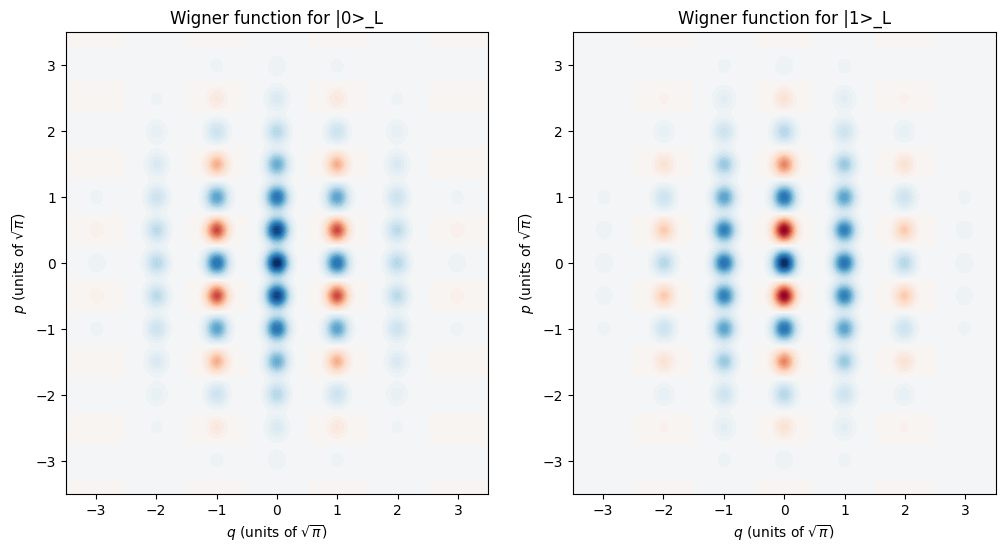

In [23]:
# Define parameters for the GKP states
theta_0, phi_0 = 0, 0  # |0>_L
theta_1, phi_1 = np.pi, 0  # |1>_L

# First quantum state |0>_L
prog1 = sf.Program(1)
with prog1.context as q:
    ops.GKP(state=[theta_0, phi_0], epsilon=0.1) | q[0]
eng = sf.Engine(backend="bosonic")
state1 = eng.run(prog1).state

# Second quantum state |1>_L
prog2 = sf.Program(1)
with prog2.context as q:
    ops.GKP(state=[theta_1, phi_1], epsilon=0.1) | q[0]
eng = sf.Engine(backend="bosonic")
state2 = eng.run(prog2).state

plot_wigner_functions([state1, state2], titles=["Wigner function for |0>_L", "Wigner function for |1>_L"])


From this visualisation of the lattice in phase space, we can see that the logical codewords (as we would expect) are orthogonal. For the  $|0\rangle_{L}$, where a column of delta functions has alternating signs, the corresponding $|1\rangle_{L}$ state has a column of solely positive delta functions, and the inverse is also true. This of course means the Wigner functions of $|0\rangle_{gkp}$ and $|1\rangle_{gkp}$ states have zero overlap, and are hence orthogonal.

If we increase the parameter $\epsilon$, the location of each of the Gaussian peaks is contracted towards the origin, and how the weights of the Gaussians are damped the further the peak is located from the origin. 

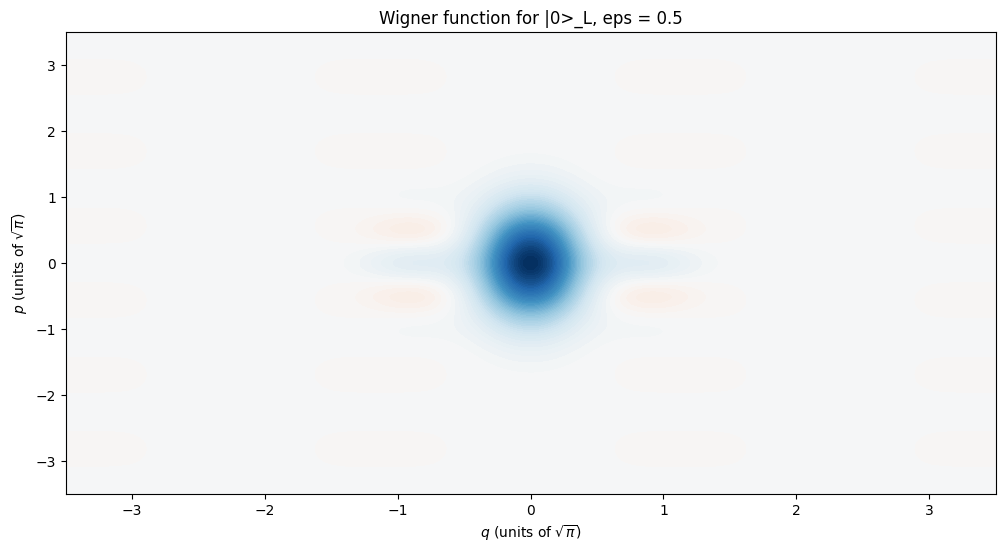

In [24]:
# Define parameters for the GKP states
theta_0, phi_0 = 0, 0  # |0>_L
# First quantum state |0>_L
prog1 = sf.Program(1)
with prog1.context as q:
    ops.GKP(state=[theta_0, phi_0], epsilon=0.5) | q[0]
eng = sf.Engine(backend="bosonic")
state1 = eng.run(prog1).state


plot_wigner_functions([state1], titles=["Wigner function for |0>_L, eps = 0.5"])

We can also visualise how the probability of measuring a certain value for the $x$ quadrature changes as epsilon increases.

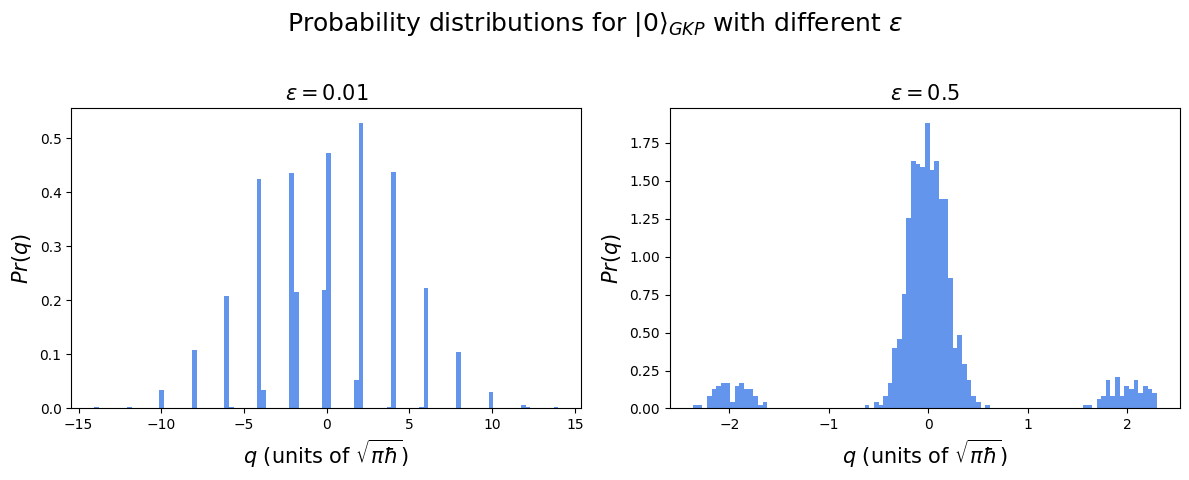

In [4]:
# Set the number of shots for the measurements
shots = 8192
scale = np.sqrt(sf.hbar * np.pi)
quad_axis = np.linspace(-6, 6, 1000) * scale

# Program for |0>_L epsilon = 0.01
prog_gkp_0_01 = sf.Program(1)
with prog_gkp_0_01.context as q:
    sf.ops.GKP(state=[0,0], epsilon=0.01) | q
    sf.ops.MeasureX | q
eng = sf.Engine("bosonic")
gkp_samples_0_01 = eng.run(prog_gkp_0_01, shots=shots).samples[:, 0]

# Program for |0>_L epsilon = 0.5
prog_gkp_0_5 = sf.Program(1)
with prog_gkp_0_5.context as q:
    sf.ops.GKP(state=[0,0], epsilon=0.2) | q
    sf.ops.MeasureX | q
eng = sf.Engine("bosonic")
gkp_samples_0_5 = eng.run(prog_gkp_0_5, shots=shots).samples[:, 0]

# Plot the results
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle(r"Probability distributions for $|0\rangle_{GKP}$ with different $\epsilon$", fontsize=18)

# Plot for epsilon = 0.01
axs[0].hist(gkp_samples_0_01 / scale, bins=100, density=True, color="cornflowerblue")
axs[0].set_title(r"$\epsilon=0.01$", fontsize=15)
axs[0].set_xlabel(r"$q$ (units of $\sqrt{\pi\hbar}$)", fontsize=15)
axs[0].set_ylabel("$Pr(q)$", fontsize=15)

# Plot for epsilon = 0.5
axs[1].hist(gkp_samples_0_5 / scale, bins=100, density=True, color="cornflowerblue")
axs[1].set_title(r"$\epsilon=0.5$", fontsize=15)
axs[1].set_xlabel(r"$q$ (units of $\sqrt{\pi\hbar}$)", fontsize=15)
axs[1].set_ylabel("$Pr(q)$", fontsize=15)

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


As the value of $\epsilon$ rises, the variance of each peak expands, and these peaks progressively approach the origin, while the magnitudes influencing the Wigner function's size diminish exponentially with distance from the origin. Ultimately, as $\epsilon \rightarrow \infty$, the damping effect associated with Fock states becomes so dominant that the resulting state is the vacuum state.

### Clifford Operations
We know that the Clifford group is the normalizer  of the $n$ qubit Pauli group (i.e. the set of unitaries that map Pauli operators into other Pauli operators), and has generators 
- Hadamard gate
- CNOT
- S gate
For a GKP code, the logical Pauli operators are displacements by half of the respective lattice
constants, (i.e. by $\sqrt{\pi}$).
$$
\large X_L = e^{-i \sqrt{\pi} p} = S_q^{\frac{1}{2}}
$$
$$
\large \quad Z_L = e^{i \sqrt{\pi} q} = S_p^{\frac{1}{2}}
$$
Hence, the CNOT gate between two modes can be defined by:
$$
\large \text{CNOT}_{1,2} = e^{- i\hat{q}_1\hat{p}_2}
$$
with mode 1 as the control and mode 2 as the target, the CNOT displaces mode 2 by an amount equal to the coordinate of mode 1, i.e. $x_2 → x_2 +x_1$.
(Additionally, $p_2 → p_2, x_1 → x_1$, and $p_1 → p_1 − p_2$). The Hadamard and $S$ gate are:
$$
\large H = e^{i \frac{\pi}{4} (q^2 + p^2)} \quad S = e^{\frac{i}{2} q^2}
$$
It's also interesting to note $H \approx e^{i \frac{\pi}{4} (\hat{n})}$, hence the $+1$ eigenstate of
Hadamard gate is a state with photon number equal to 0 mod 4. We can use Strawberry Fields to see the action of some of the Clifford gates.

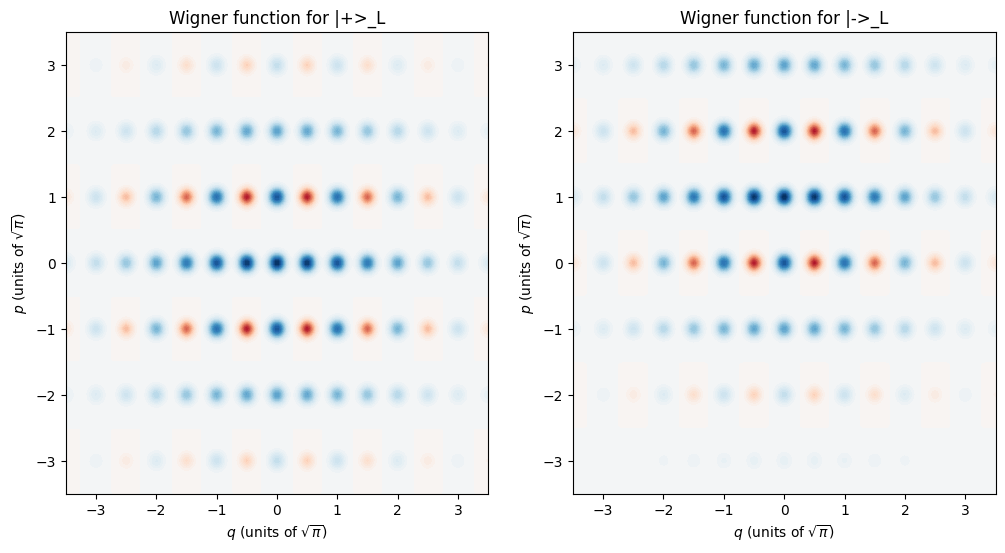

In [25]:
hadamard_angle = np.pi/2  # Used for argument for phase space rotation
x_angle = np.sqrt(np.pi)  # Used for argument for x displacement


# First quantum state |+>_L
prog1 = sf.Program(1)
with prog1.context as q:
    ops.GKP(state=[0,0], epsilon= 0.05) | q[0]  # |0>_L
    ops.Rgate(hadamard_angle) | q[0]  # Apply H to give |+>_L

# Use a new engine instance for running the first program
eng1 = sf.Engine(backend="bosonic", backend_options={"cutoff_dim": 10})
state1 = eng1.run(prog1).state

# Second quantum state |->_L
prog2 = sf.Program(1)
with prog2.context as q:
    ops.GKP(state=[0, 0], epsilon=0.05) | q[0]  # |0>_L
    ops.Xgate(x_angle) | q[0]  # Apply X gate
    ops.Rgate(hadamard_angle) | q[0]  # Apply H to give |->_L

# Use another new engine  for running the second program
eng2 = sf.Engine(backend="bosonic", backend_options={"cutoff_dim": 10})
state2 = eng2.run(prog2).state

plot_wigner_functions([state1, state2], titles=["Wigner function for |+>_L", "Wigner function for |->_L"])



### Resistance to Small Displacements

https://arxiv.org/abs/1908.00147 Sec 3.3

https://arxiv.org/abs/2106.12989 Sec. III (c)

A key feature of GKP states is that they are resistant to small shift/displacement errors (in both quadratures). The stabilizers  possess a continuous spectrum of eigenvalues situated on the unit circle within the complex plane. This means that confining the code space to have stabilizer eigenvalues exactly equal to +1 imposes significant constraints. Consider the scenario where we have an arbitrary, ideal GKP state $\psi = \alpha|0\rangle_L + \beta|1\rangle_L$, which is inherently stabilized by the operator $\hat{S}_q$ with an eigenvalue of +1. If this state encounters a minor shift error $u$ along the $q$ quadrature, the eigenvalue attributed to $\hat{S}_q$ deviates from +1. This deviation is also applicable to shift errors in the $p$ quadrature with respect to $\hat{S}_p$. Then the measurement of $S_x$ yields a phase which deviates the eigenvalue from +1:
$$
\hat{S}_q e^{-iu\hat{p}}|\bar{\psi}\rangle = e^{i2\sqrt{\pi}\hat{q}}e^{-iu\hat{p}}|\bar{\psi}\rangle = e^{-iu\hat{p}}e^{i2\sqrt{\pi}\hat{q}}e^{2\sqrt{\pi}u[\hat{q},\hat{p}]}|\bar{\psi}\rangle = e^{i2\sqrt{\pi}u}e^{-iu\hat{p}}|\bar{\psi}\rangle
$$
where we use $e^Ae^B = e^B e^A e^{[A,B]}$.
We can measure the phase by applying a controlled $S_q$ on the qubit, with the ancilla qubit in the $|+\rangle$ state as control, e.g. applying
$$
U_q = I \otimes |\uparrow\rangle\langle \uparrow| + S_q \otimes |\downarrow\rangle\langle \downarrow|,
$$
then measuring ancilla in $X$ basis will give us the real parts:
$$\langle + x | \langle \Psi | U_{\lambda}^{\dagger} X U_{\lambda} | \Psi \rangle | + x \rangle = \text{Re} \langle \Psi | S_{\lambda} | \Psi \rangle $$
and measuring in $Y$ basis the imaginary
$$\langle + x | \langle \Psi | U_{\lambda}^{\dagger} Y U_{\lambda} | \Psi \rangle | + x \rangle = \text{Im} \langle \Psi | S_{\lambda} | \Psi \rangle $$
parts of the error syndrome. This clearly requires the use of a transmon as an ancilla, which has its own imperfections.

An alternative approach, which is the approach that has been studied most extensively in the theoretical literature on GKP codes \[[1](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.64.012310), [2](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.99.032344)\], is to use ancillae that are themselves prepared in GKP states. Here, phase estimation can be performed in a single shot (assuming we can perform high-efficiency homodyne detection), with an accuracy set by the quality of the encoded GKP ancilla states (and the measurement efficiency). So what's the idea here?

We'll first consider $q$ quadrature displacements. Consider an input qubit with a shift error $u_1$ and an ancilla qubit in the state $|+\rangle_L$, affected by a shift error $u_2$. The initial combined state, omitting normalization, is given by:

$$
e^{-iu_1\hat{p}_1} e^{-iu_2\hat{p}_2} |\psi\rangle |+\rangle.
$$

For correcting shifts in the $\hat{q}$ quadrature, we first apply a CNOT. The action of the CNOT gate on shift errors transforms the system's state to:

$$
e^{-iu_1\hat{p}_1} e^{-i(u_1+u_2)\hat{p}_2} |\psi\rangle_1 |+\rangle_2,
$$

where indices 1 and 2 denote the control and target qubits of the CNOT gate, respectively. Using the definition of ideal GKP code states, the output state can be expressed as a sum over integers $s, s'$:

$$
\large \sum_{s,s' \in \mathbb{Z}} \ \alpha |q_1 = 2s\sqrt{\pi}|q_2 = (2s+ s') \sqrt{\pi} + u\rangle + \beta |q_1 = (2s+1)\sqrt{\pi} + u\rangle |q_2 = (2s + 1 + s')\sqrt{\pi} + u\rangle,
$$
which simplifies to:

$$
\large \sum_{n_0,n_1 \in \mathbb{Z}} \left( \alpha |q_1 = 2n_0\sqrt{\pi} + u_1\rangle + \beta |q_1 = (2n_0 + 1)\sqrt{\pi} + u_1\rangle \right) |q_2 = n_1\sqrt{\pi} + u_1 + u_2\rangle,
$$

where $|\psi\rangle_L = \alpha |0\rangle_L + \beta |1\rangle_L$ and $|\alpha|^2 + |\beta|^2 = 1$ (i.e. 'factoring out' the ancilla state).
When the ancilla is measured (homodyne), the outcome $(q_{\text{out}}$ is $u_1 + u_2 + n_1\sqrt{\pi}$ with certainty, where $n_1 \in \mathcal{Z}$). This measurement preserves the quantum information encoded in the coefficients  and leaves the input state unaffected. Then, the correction term $q_{\text{cor}} = q_{\text{out}} \mod \sqrt{\pi}$, which falls within the interval $[-\frac{\sqrt{\pi}}{2}, \frac{\sqrt{\pi}}{2}]$, is used for the correction operator $e^{iq_{\text{cor}}\hat{p}}$. Consequently, the state of the input qubit, disregarding certain phase factors, evolves to:

$$
\sum_{s \in \mathbb{Z}} \left( \alpha |q_1 = 2s\sqrt{\pi} - u_2 - n_1\sqrt{\pi}\rangle + \beta |q_1 = (2s + 1)\sqrt{\pi} - u_2 - n_1\sqrt{\pi}\rangle \right) = e^{in_1\sqrt{\pi}\hat{p}}e^{iu_2\hat{p}}|\psi\rangle,
$$

This adjustment effectively aligns the code states with the nearest integer multiple of $\sqrt{\pi}$, augmented by a minor shift error $u_2$ attributable to the ancilla. The operation $e^{in_1\sqrt{\pi}}$ acts as a logical $\overline{X}$operator for odd $n_1$ and as the identity for even $n_1$. The procedure mirrors in the $\hat{p}$ quadrature with the reversal of the CNOT gate and the ancilla prepared in $|0\rangle_L$, culminating in a $\hat{p}$ (heterodyne) measurement.

So, in the $\hat{q}$ quadrature, the data qubit's shift errors transform as $u_1 \rightarrow -u_2$ and $v_1 \rightarrow v_1 - v_2$, contingent upon the success condition $|u_1 + u_2| < \frac{\sqrt{\pi}}{2}$. Analogously, in the $\hat{p}$ quadrature, the transformation is $u_1 \rightarrow u_1 + u_2$, $v_1 \rightarrow v_2$, with a success criterion of $|v_2 - v_1| < \frac{\sqrt{\pi}}{2}$. Here, $u$ and $v$ denote shift errors in the $\hat{q}$ and $\hat{p}$ quadratures, respectively, with subscripts 1 and 2 designating the data and ancilla qubits. Notably, the sign of the shift errors is irrelevant, as any Gaussian-distributed variable $u$ with a zero mean exhibits an identical probability distribution for $u$ and $-u$.

Let's do this with a simple example!

Program execution done in 158.45 seconds


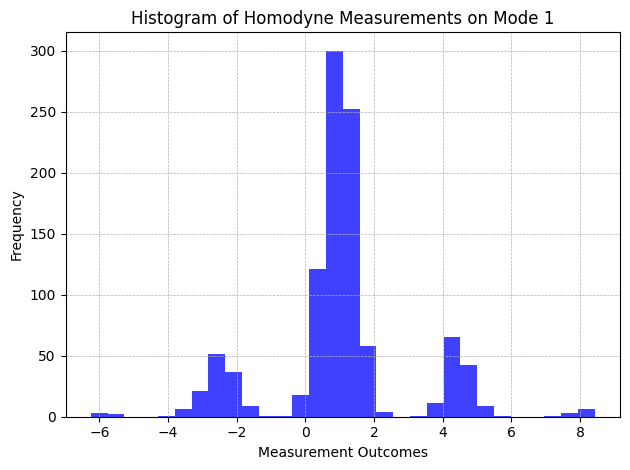

In [17]:
# Start timing for program execution
start_time_program = time.time()

# Define the program
prog = sf.Program(2)

with prog.context as q:
    ops.GKP(state=[0, 0], epsilon=0.2) | q[0]
    ops.GKP(state=[0, np.pi/2], epsilon=0.2) | q[1]

    #shift in q quadrature
    ops.Xgate(1.0) | q[0] 
    
    ops.CXgate(s=1) | (q[0], q[1])
    ops.MeasureX | q[1]  # Measure mode 1

# Specify the number of shots
shots = 1024

# Run the program on the bosonic backend with multiple shots
eng = sf.Engine(backend="bosonic", backend_options={"cutoff_dim": 10})
result = eng.run(prog, shots=shots)

# Collect measurement results for mode 1
measurement_results = result.samples[:, 0] 

# End timing for program execution
end_time_program = time.time()
print(f"Program execution done in {end_time_program - start_time_program:.2f} seconds")

# Plot histogram of measurement results
plt.hist(measurement_results, bins=30, alpha=0.75, color='blue')
plt.xlabel('Measurement Outcomes')
plt.ylabel('Frequency')
plt.title('Histogram of Homodyne Measurements on Mode 1')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

In [19]:
mean_value = np.mean(measurement_results)

print(f"Mean Measurement Value: {mean_value}")


Mean Measurement Value: 1.0406623597012659


We can see that the second mode has 'picked up' the displacement of the first mode (on average). Recall we see a spread around the peaks at $n\sqrt{\pi}$ as we are working with finite energy approximate GKP states. Finite energy GKP states introduce a Gaussian spread in wavefunction peaks due to the Fock damping operator $e^{-\epsilon \hat{n}}$, affecting error correction precision. For error correction with ancilla measurements the measurement outcome used for displacement correction will not be exact due to the Gaussian spread. Reducing $\epsilon$ decreases the spread, approaching ideal GKP behavior. However, some uncertainty remains, necessitating strategies such as repetition for averaging or adaptive correction for effective QEC in finite energy GKP states.